<a href="https://colab.research.google.com/github/hyang0129/NGAFIDDATASET/blob/main/NGAFID_DATASET_MINIROCKET_EXAMPLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hyang0129/NGAFIDDATASET.git

!(cd NGAFIDDATASET ; git checkout main; git reset --hard HEAD; git pull)
!(cd NGAFIDDATASET ; pip install -r requirements.txt -q)

!pip install tsai -q 

fatal: destination path 'NGAFIDDATASET' already exists and is not an empty directory.
Already on 'main'
Your branch is up to date with 'origin/main'.
HEAD is now at 0b6d8bd add get np dataset
Already up to date.


In [2]:
%load_ext autoreload


In [3]:
import sys 
sys.path.append('/content/NGAFIDDATASET')

In [4]:
%autoreload
from ngafiddataset.dataset.dataset import NGAFID_Dataset_Manager
from ngafiddataset.utils import connect_to_tpu

from tsai.basics import *
from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *
import pandas as pd 


# strategy = connect_to_tpu()

/content/NGAFIDDATASET/ngafiddataset/dataset/dataset.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:

dm = NGAFID_Dataset_Manager('2days')
df = pd.read_csv('/content/2days/flight_header.csv')

dm.data_dict =  dm.construct_data_dictionary(numpy=True)


2022-05-15 17:52:53.572 | INFO     | ngafiddataset.dataset.dataset:download:39 - Extracting File


  0%|          | 0/16034 [00:00<?, ?it/s]

In [6]:
number_classes = len(dm.flight_header_df['class'].unique())
number_classes

number_hierarchies = len(dm.flight_header_df['hclass'].unique())
number_hierarchies


6

In [7]:

mode = 'before_after'


train_dict = dm.get_numpy_dataset(fold = 0, training = True)
test_dict = dm.get_numpy_dataset(fold = 0, training  = False)


In [28]:
train_X = np.array(train_dict['data'], dtype = np.float32)

train_X = (train_X - dm.mins)/(dm.maxs - dm.mins)
train_X = np.nan_to_num(train_X, copy = False)

test_X = np.array(test_dict['data'], dtype = np.float32)
test_X = (test_X- dm.mins)/(dm.maxs - dm.mins)
test_X = np.nan_to_num(test_X, copy = False)

In [31]:
train_Y = np.array(train_dict['before_after'])
test_Y = np.array(test_dict['before_after'])

In [36]:
splits = [list(np.arange(len(train_Y)))]

splits.append(list(np.arange(len(test_Y) )+ len(train_Y)))


In [40]:

torch.cuda.empty_cache()
mrf = MiniRocketFeatures(train_X.shape[1], train_X.shape[2]).to(default_device())
chunksize = 64

mrf.fit(train_X, chunksize = chunksize)

X_feat = get_minirocket_features(np.concatenate([train_X, test_X]), mrf, chunksize=chunksize, to_np=True)
X_feat.shape

(16034, 9996, 1)

In [41]:
Y = np.concatenate([train_Y, test_Y])

In [42]:
PATH = Path("./models/MRF.pt")
PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(mrf.state_dict(), PATH)

SuggestedLRs(valley=2.511886486900039e-05)

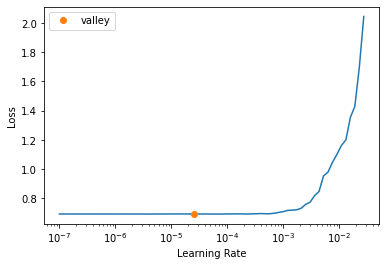

In [46]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, Y , splits = splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(MiniRocketHead, dls=dls)

learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
learn.lr_find()            



epoch,train_loss,valid_loss,accuracy,time
0,0.483099,0.731625,0.567197,00:01
1,0.477966,0.735790,0.560025,00:01
2,0.482602,0.734610,0.569068,00:01
3,0.481685,0.733310,0.572809,00:01
4,0.477164,0.736661,0.570003,00:01
5,0.479903,0.734702,0.566885,00:01
6,0.478207,0.733704,0.567509,00:01
7,0.478862,0.741358,0.569380,00:01
8,0.478852,0.740559,0.570315,00:01
9,0.486333,0.740340,0.570315,00:01


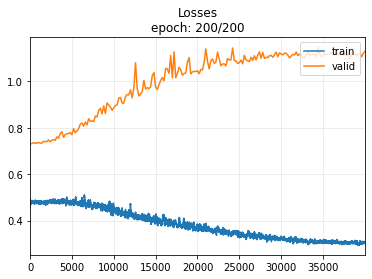

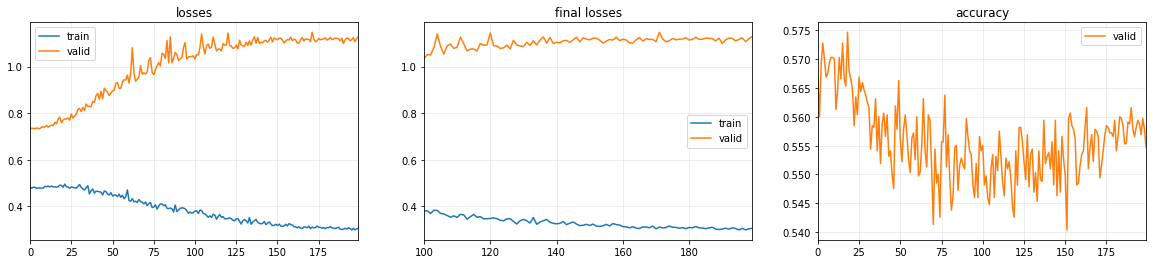

In [48]:
learn.fit_one_cycle(200, 2.5e-4)
